In [174]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<h3><center>Exploratory analysis</center></h3>

<h4>Load Data from Database</h4>

In order for us to begin the data exploration and understanding step, we need to collect the data that has already been treated and that were entered into our database, in the previous step.

For this, let's run the step below, creating a Pandas Dataframe, which will contain all the Bitcoin history we want.

In [175]:
# create database file and engine
engine = create_engine('sqlite:///database/database.db', echo=False)

# define query to run
query = """select
                  date
                , open
                , high
                , low
                , close
                , volume
           from historical"""

# read sql from database using query
frame = pd.read_sql(
    query, 
    con=engine,
    parse_dates=['date']
)

<h4>Next day closing</h4>

The intention of the study is to predict, based on current day data, the closing price of Bitcoin the following day. 

Based on this, we will create a new column of data, with the next days closing price, and this column will be the variable we want to predict at the end of the study.

We also created a column that tells us the percentage of change, or variation, between the close of one day and the next, this column was named "percentual_change".

In [176]:
frame['closing_next'] = frame['close'].shift(-1)
frame['percentual_change'] = frame.close.pct_change()
frame.head()

,date,open,high,low,close,volume,closing_next,percentual_change
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,424.440002,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,394.795990,-0.071926
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,408.903992,-0.069843
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,398.821014,0.035735
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,402.152008,-0.024659


<h4>Dates</h4>

The data covers a period between 17/09/2014 and 09/07/2021, with a total of 2488 days.

In [177]:
first_date = frame.date.dt.date.min()
last_date = frame.date.dt.date.max()
total_days = frame.shape[0]
print('The lowest date in the data is %s and the highest date is %s. A total of %s days.' % (first_date, last_date, total_days))

The lowest date in the data is 2014-09-17 and the highest date is 2021-07-09. A total of 2488 days.


<h4>Viewing the closing price history</h4>

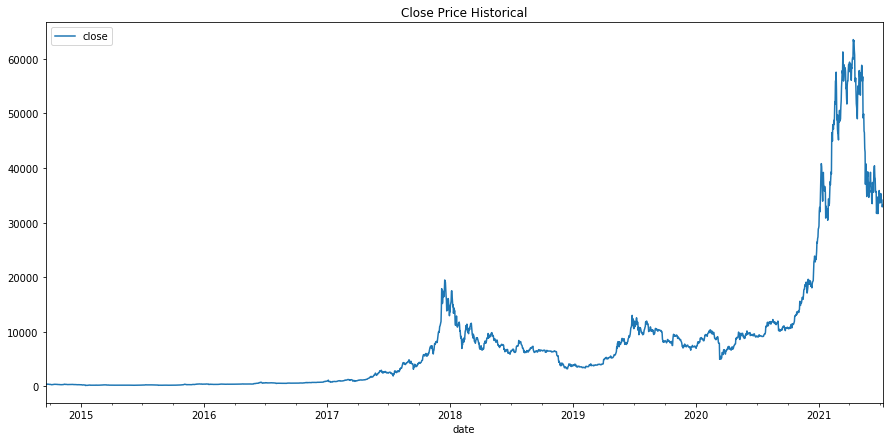

In [178]:
frame[['close', 'date']].plot(figsize=(15,7), title='Close Price Historical', x='date')

<h4>Highest closing value</h4>

In [179]:
max_date = frame.loc[frame.close.sort_values(ascending=False).index[0],'date']
max_value = frame.loc[frame.close.sort_values(ascending=False).index[0],'close']
print('The highest closing value of the historical series for Bitcoin was %s, on the day %s' % (max_value, max_date))

The highest closing value of the historical series for Bitcoin was 63503.457031, on the day 2021-04-13 00:00:00


<h4>Highest closing and percentage change year by year</h4>

In five of the seven possible years to be analyzed, Bitcoin has grown in value. The year in which its value varied the most was in 2017, when it grew 1800% over the previous year.

In the years 2018 and 2019, there was a decrease compared to the previous year, with 10% in 2018 and 25% in 2019.

In the last two years, growth has been more modest, practically doubling its value year on year.

,date,close,percentage_change
0,2014,457.334015,NaN
1,2015,465.321014,0.017464
2,2016,975.921021,1.097307
3,2017,19497.400391,18.978461
4,2018,17527.000000,-0.101060
5,2019,13016.231445,-0.257361
6,2020,29001.720703,1.228120
7,2021,63503.457031,1.189644


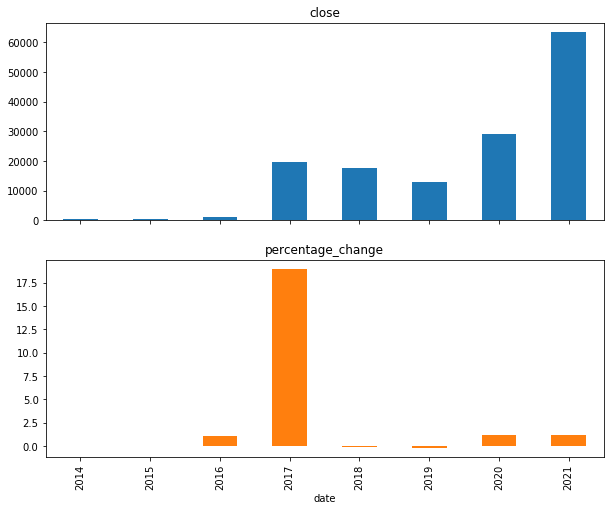

In [180]:
highest_year = pd.merge(
    frame.date.dt.year,
    frame.close,
    how='inner',
    left_index=True,
    right_index=True
).groupby('date').agg('max').reset_index()

highest_year['percentage_change'] = (highest_year.close/highest_year.close.shift(1))-1

highest_year.plot(kind='bar', legend=False, figsize=(10, 8),x='date', subplots=True)

highest_year

<h4>Accumulated Volume</h4>

The value added per year, of the volume traded in Bitcoin, has grown at an exponential pace, year after year. In 2020, the volume reached the mark of 11.670 billion dollars. The partial mark of 2021 (as of 07/09/21) is already 11.374 billion.

,date,volume
0,2014,2.53
1,2015,12.38
2,2016,31.45
3,2017,869.75
4,2018,2213.20
5,2019,6106.63
6,2020,11670.09
7,2021,11374.31


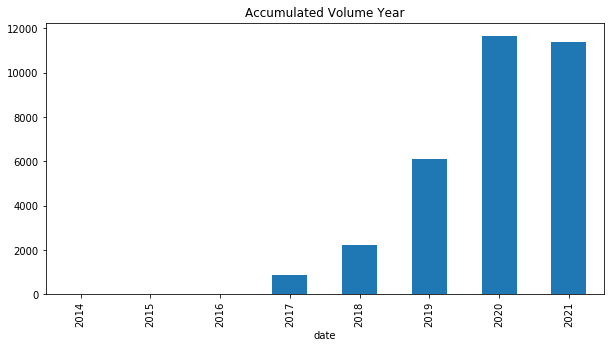

In [181]:
accumulated_volume = pd.merge(
    frame.date.dt.year,
    frame.volume,
    how='inner',
    left_index=True,
    right_index=True
).groupby('date').agg('sum').reset_index()
accumulated_volume['volume'] = accumulated_volume['volume'].apply(lambda x: float(round((x/1000000000), 2)))
accumulated_volume.plot(kind='bar', x='date', y='volume', figsize=(10,5), legend=False, title='Accumulated Volume Year')
accumulated_volume

<h4>Percentage Change Distribution</h4>

Plotting the histogram of the distribution of percentage change values between the closing prices, we can see that the mean is 0.25% with a standard deviation of 3.93%.

As the average is slightly positive, we understand that over time, despite constant drops in prices, Bitcoin appreciates.

The median of the distribution is 0.19%, very close to the mean. The biggest drop was 37.16% and the biggest increase was 25.24%.

count    2487.000000
mean        0.002505
std         0.039336
min        -0.371695
25%        -0.012740
50%         0.001988
75%         0.018052
max         0.252472
Name: percentual_change, dtype: float64

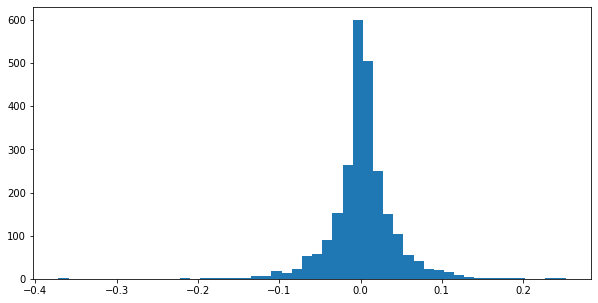

In [182]:
frame.percentual_change.hist(bins=50, grid=False, figsize=(10,5))
frame.percentual_change.describe()

<h4>Correlation matrix</h4>

All variables have a strong positive correlation (> 0.7) with our target variable (closing_next). The traded volume has the lowest correlation, being 0.79. The highest correlation is for the variable "close" being 0.998.

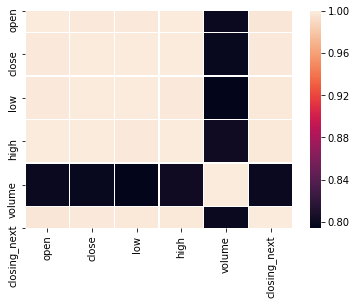

,open,close,low,high,volume,closing_next
open,1.000000,0.998572,0.998837,0.999415,0.800019,0.997327
close,0.998572,1.000000,0.999252,0.999380,0.798781,0.998559
low,0.998837,0.999252,1.000000,0.998773,0.793953,0.997772
high,0.999415,0.999380,0.998773,1.000000,0.802335,0.997998
volume,0.800019,0.798781,0.793953,0.802335,1.000000,0.799469
closing_next,0.997327,0.998559,0.997772,0.997998,0.799469,1.000000


In [183]:
correlation_data = frame[['open', 'close', 'low', 'high', 'volume', 'closing_next']].corr()
ax = sns.heatmap(correlation_data, linewidth=0.5)
plt.show()
correlation_data

As our goal is to predict the closing value of Bitcoin the day after the valued one, and based on what we explored above, the closing value, open, maximum and minimum variables help to explain the close of the next day.

Based on this, we will use this same Dataframe to try to create a model that can perform the desired forecast, within the metrics we have established.